In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=UserWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# Time series analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, KFold

In [ ]:
# Reading the csv sheet
df = pd.read_csv('/content/Gold Price.csv')
print("Data Shape:", df.shape)
print(df.head())

Data Shape: (2583, 7)
         Date     Price      Open      High       Low     Vol. Change %
0  12/30/2022  1,826.20  1,821.80  1,832.40  1,819.80  107.50K    0.01%
1  12/29/2022  1,826.00  1,812.30  1,827.30  1,811.20  105.99K    0.56%
2  12/28/2022  1,815.80  1,822.40  1,822.80  1,804.20  118.08K   -0.40%
3  12/27/2022  1,823.10  1,808.20  1,841.90  1,808.00  159.62K    0.74%
4  12/26/2022  1,809.70  1,805.80  1,811.95  1,805.55      NaN    0.30%


### **Exploratory Data Analysis**

In [ ]:
# Removing data before 2017
df = df.drop(df.index[1550:])
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1545,01/09/2017,"1,186.30","1,174.90","1,187.20","1,174.60",0.21K,0.98%
1546,01/06/2017,"1,174.80","1,179.70","1,180.10","1,172.60",0.19K,-0.66%
1547,01/05/2017,"1,182.60","1,165.30","1,186.50","1,165.30",0.20K,1.38%
1548,01/04/2017,"1,166.50","1,158.10","1,168.50","1,158.10",0.24K,0.28%
1549,01/03/2017,"1,163.20","1,154.00","1,165.00","1,148.10",0.22K,0.89%


In [ ]:
#checking for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        4
Change %    0
dtype: int64


In [ ]:
# Dropping unnecessary columns
df.drop(['Open','High','Low','Vol.', 'Change %'], axis=1, inplace=True)

In [ ]:
# Date formatting
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending = False, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df.set_index('Date', inplace=True)

# Making the data weekly
weekly_df = df.resample('W').mean()
print(weekly_df.head())
print("Total data points:", len(weekly_df))

               Price
Date                
2017-01-08  1171.775
2017-01-15  1193.980
2017-01-22  1209.880
2017-01-29  1201.620
2017-02-05  1211.180
Total data points: 313


In [ ]:
# summary
summary_stats = weekly_df["Price"].describe()
print("Summary Statistics\n", summary_stats)

Summary Statistics
 count     313.000000
mean     1552.398482
std       260.558345
min      1171.775000
25%      1288.880000
50%      1535.840000
75%      1800.220000
max      2019.340000
Name: Price, dtype: float64


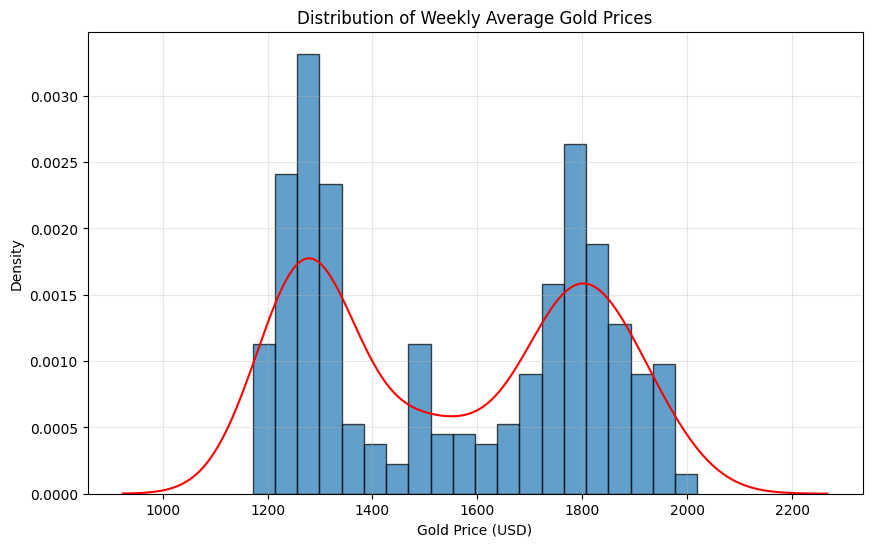

In [ ]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(weekly_df['Price'], bins=20, edgecolor='black', alpha=0.7, density=True)
sns.kdeplot(weekly_df['Price'], color='red')
plt.xlabel('Gold Price (USD)')
plt.ylabel('Density')
plt.title('Distribution of Weekly Average Gold Prices')
plt.grid(True, alpha=0.3)
plt.show()

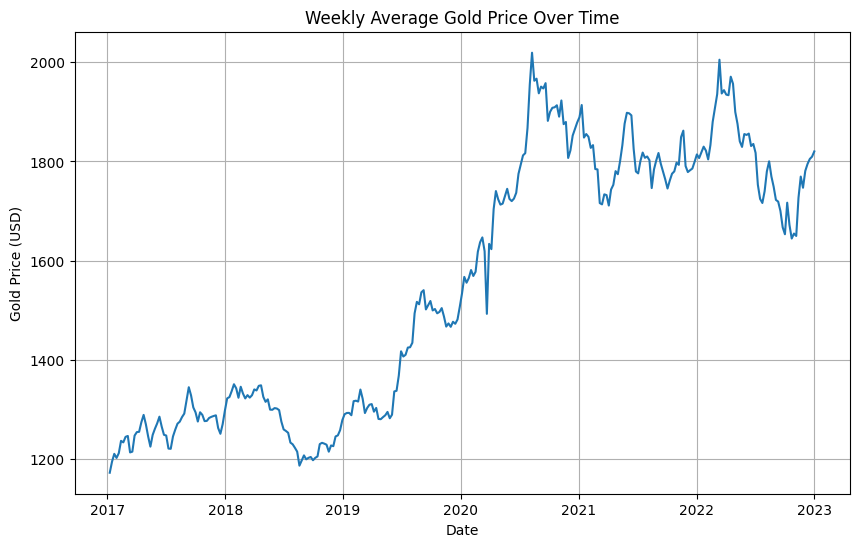

In [ ]:
# Plotting the gold price over time
plt.figure(figsize=(10, 6))
plt.plot(weekly_df.index, weekly_df['Price'])
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Weekly Average Gold Price Over Time')
plt.grid(True)
plt.show()

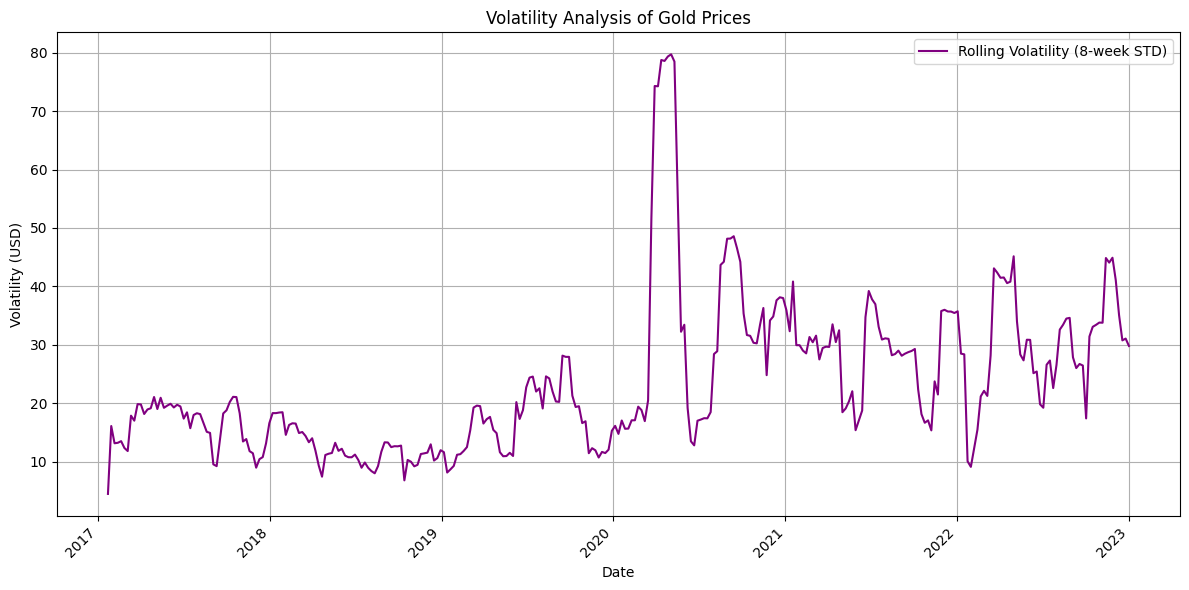


Volatility Summary Statistics:
count    311.000000
mean      23.287505
std       13.090658
min        4.458308
25%       13.453215
50%       19.261279
75%       30.290867
max       79.734441
Name: Volatility, dtype: float64


In [ ]:
weekly_df['Price_diff'] = weekly_df['Price'].diff()
weekly_df = weekly_df.dropna()  # Drop rows with NaN

# Window size for rolling volatility
window_size = 8

# Rolling volatility (standard deviation of Price_diff)
weekly_df['Volatility'] = weekly_df['Price_diff'].rolling(window=window_size, min_periods=1).std()

# Plot volatility over time
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['Volatility'], label='Rolling Volatility (8-week STD)', color='purple')
plt.title('Volatility Analysis of Gold Prices')
plt.xlabel('Date')
plt.ylabel('Volatility (USD)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set to show years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

# Summary
print("\nVolatility Summary Statistics:")
print(weekly_df['Volatility'].describe())

In [ ]:
# ADF test
result = adfuller(weekly_df['Price'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Stationarity check
if result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary")

ADF Statistic: -1.1460894473446028
p-value: 0.6963465892942327
Critical Values: {'1%': np.float64(-3.451552879535732), '5%': np.float64(-2.8708786756338407), '10%': np.float64(-2.571745666091128)}
Data is non-stationary


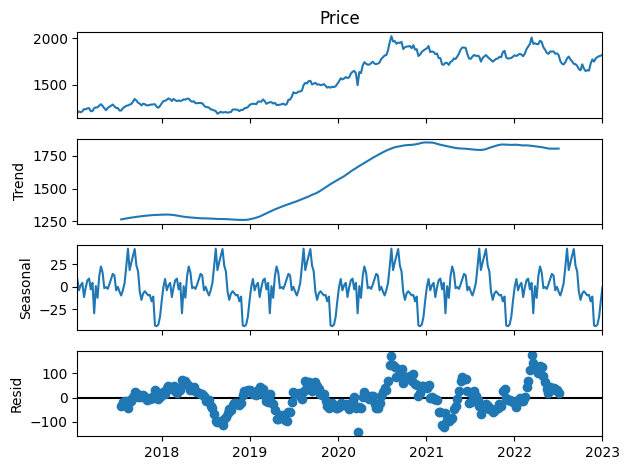

In [ ]:


result = seasonal_decompose(weekly_df['Price'], model='additive', period=52)

# Plot
result.plot()
plt.tight_layout()
plt.show()

In [ ]:
#First order Differencing
weekly_df['Price_diff'] = weekly_df['Price'].diff()

weekly_df = weekly_df.dropna()

result_diff = adfuller(weekly_df['Price_diff'])

print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

# Stationarity check
if result_diff[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary")

ADF Statistic: -16.893197410530608
p-value: 1.04127717006965e-29
Critical Values: {'1%': np.float64(-3.451621854687657), '5%': np.float64(-2.870908950689806), '10%': np.float64(-2.571761810613944)}
Data is stationary


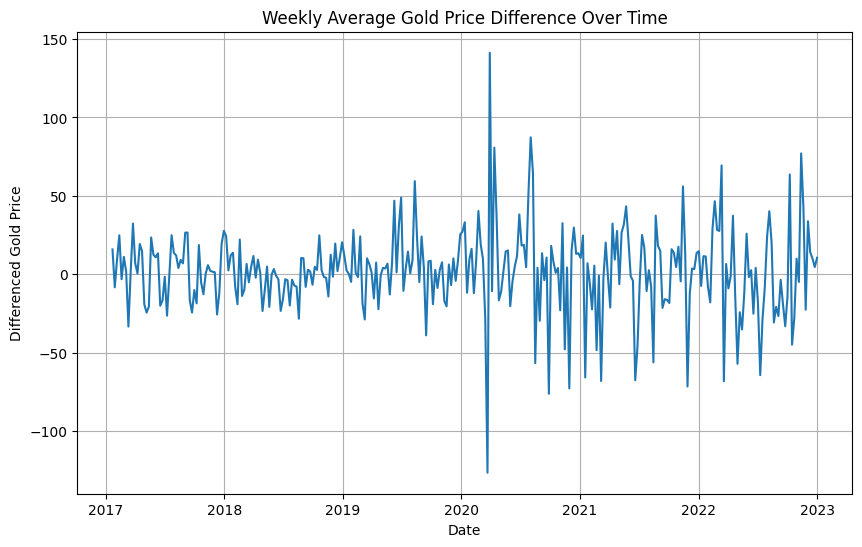

In [ ]:
# After differencing line chart
plt.figure(figsize=(10, 6))
plt.plot(weekly_df.index, weekly_df['Price_diff'])
plt.xlabel('Date')
plt.ylabel('Differenced Gold Price')
plt.title('Weekly Average Gold Price Difference Over Time')
plt.grid(True)
plt.show()

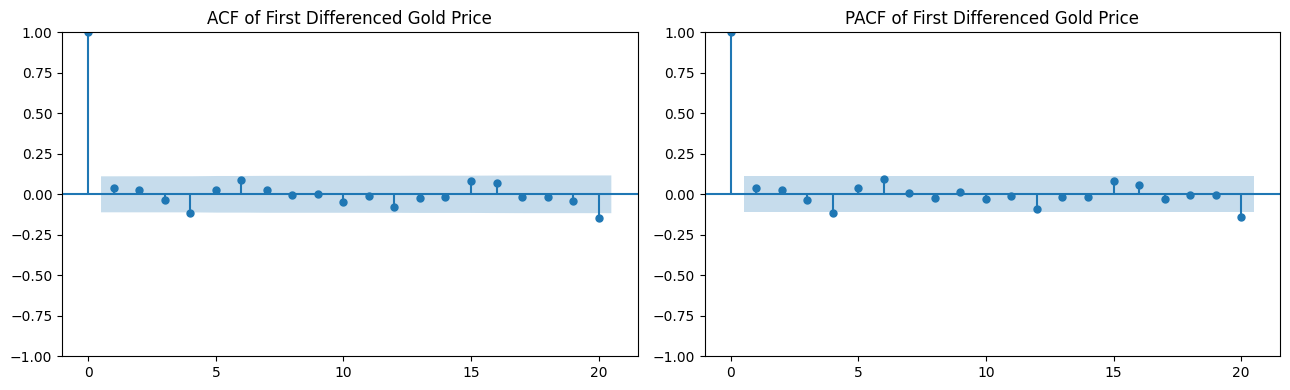

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ACF plot
plot_acf(weekly_df['Price_diff'], lags=20, ax=axes[0])
axes[0].set_title('ACF of First Differenced Gold Price')

# PACF plot
plot_pacf(weekly_df['Price_diff'], lags=20, ax=axes[1])
axes[1].set_title('PACF of First Differenced Gold Price')

plt.tight_layout()
plt.show()


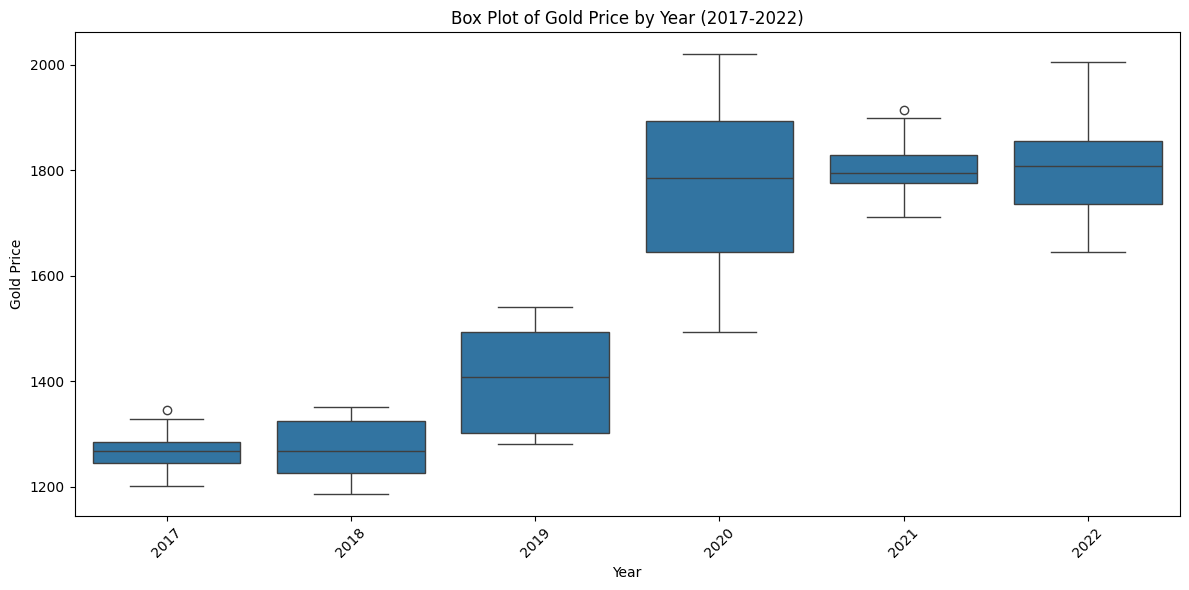

In [ ]:
import matplotlib.pyplot as plt

weekly_df['Year'] = weekly_df.index.year

# Filter data for years 2017-2022
filtered_df = weekly_df[(weekly_df['Year'] >= 2017) & (weekly_df['Year'] <= 2022)]

# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Price', data=filtered_df)
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.title('Box Plot of Gold Price by Year (2017-2022)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Splitting Data**

In [ ]:
train_data = weekly_df['Price'][:234]  # 75% for training
test_data = weekly_df['Price'][234:]   # Remaining 25% for testing

### **Modelling**

**ARIMA**

In [ ]:
arima_model = ARIMA(train_data, order=(0,1,4))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
arima_rmse

np.float64(76.69292944883475)

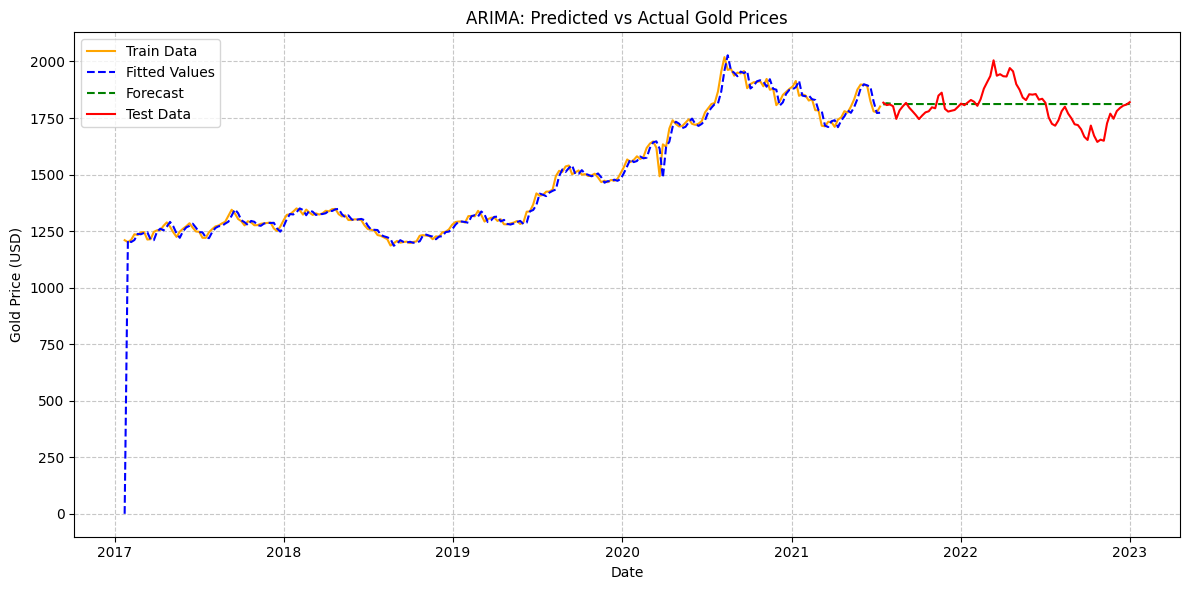

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data', color = 'orange')
plt.plot(arima_fit.fittedvalues, label='Fitted Values', color='blue', linestyle='--')
plt.plot(arima_forecast, label='Forecast',color = 'green', linestyle='--')
plt.plot(test_data, label='Test Data', color='red')
plt.title('ARIMA: Predicted vs Actual Gold Prices', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Gold Price (USD)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**AICC and BIC values for ARIMA**

In [ ]:
arima_model = ARIMA(train_data, order=(1,1,1))
arima_fit = arima_model.fit()
print(arima_fit.bic)

2192.7404434281952


In [ ]:
arima_model = ARIMA(train_data, order=(1,1,0))
arima_fit = arima_model.fit()
print(arima_fit.bic)

2187.47755336137


In [ ]:
arima_model = ARIMA(train_data, order=(2,1,2))
arima_fit = arima_model.fit()
print(arima_fit.bic)

2200.6998760743018


In [ ]:
arima_model = ARIMA(train_data, order=(2,1,1))
arima_fit = arima_model.fit()
print(arima_fit.bic)

2196.5396866967185


In [ ]:
arima_model = ARIMA(train_data, order=(0,1,1))
arima_fit = arima_model.fit()
print(arima_fit.bic)

2187.4812488918824


In [ ]:
arima_model = ARIMA(train_data, order=(0,1,4))
arima_fit = arima_model.fit()
print(arima_fit.aicc)

2182.6930787035362


In [ ]:
arima_model = ARIMA(train_data, order=(0,1,0))
arima_fit = arima_model.fit()
print(arima_fit.aicc)

2178.618154637059


**Double Exponential Smoothing**

In [ ]:
des_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
des_fit = des_model.fit(optimized=True)
des_forecast = des_fit.forecast(len(test_data))

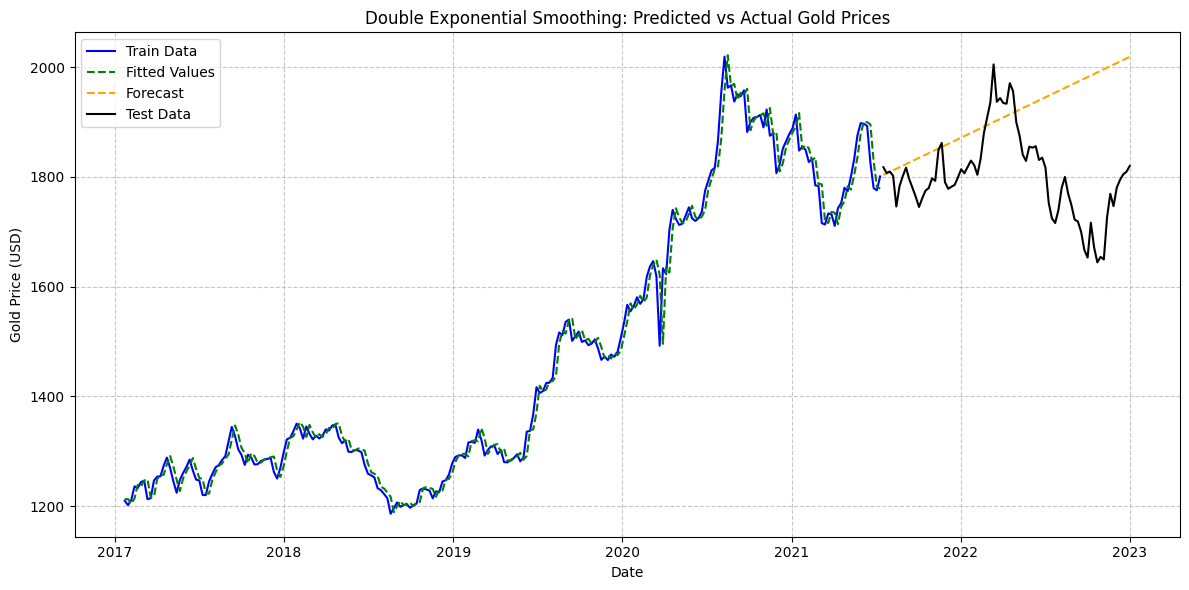

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data', color='blue')
plt.plot(des_fit.fittedvalues, label='Fitted Values', color='green', linestyle='--')
plt.plot(des_fit.forecast(steps=len(test_data)), label='Forecast', color='orange', linestyle='--')
plt.plot(test_data, label='Test Data', color='black')
plt.title('Double Exponential Smoothing: Predicted vs Actual Gold Prices', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Gold Price (USD)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Triple Exponential Smoothing**

In [ ]:
tes_model = ExponentialSmoothing(
    train_data,
    trend='add',
    seasonal='add',
    seasonal_periods=52
)
tes_fit = tes_model.fit(optimized=True)
tes_forecast = tes_fit.forecast(len(test_data))
tes_rmse = np.sqrt(mean_squared_error(test_data, tes_forecast))

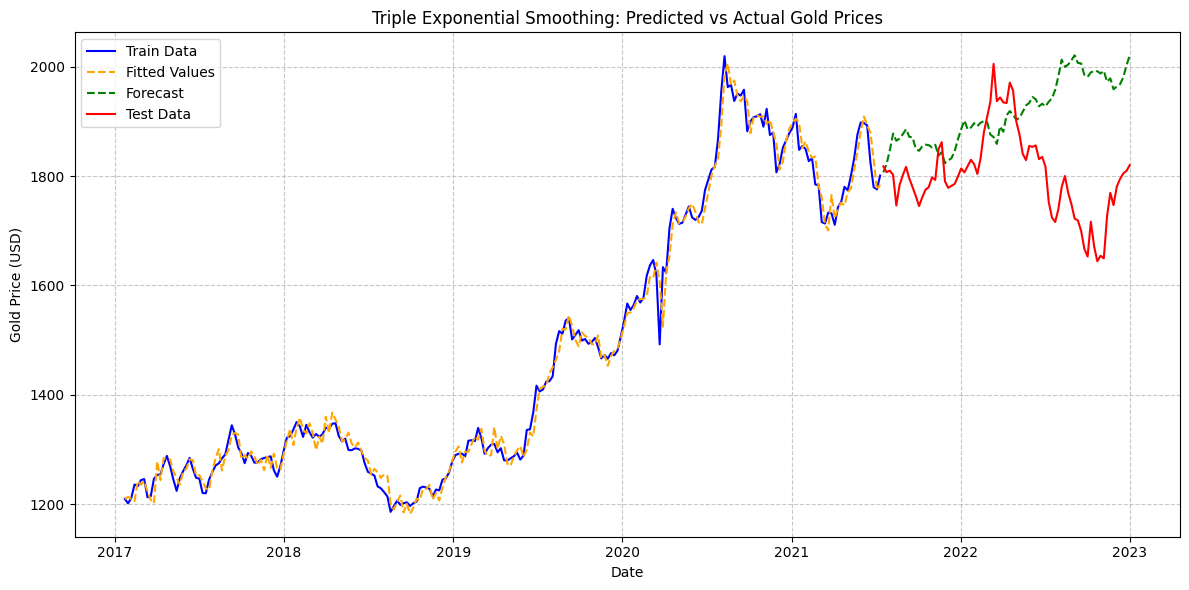

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data',color = 'blue')
plt.plot(tes_fit.fittedvalues, label='Fitted Values',color = 'orange', linestyle='--')
plt.plot(tes_fit.forecast(steps=len(test_data)), label='Forecast',color = 'green', linestyle='--')
plt.plot(test_data, label='Test Data',color = 'red')
plt.title('Triple Exponential Smoothing: Predicted vs Actual Gold Prices', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Gold Price (USD)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Random Forest**

In [ ]:
weekly_df['Lag1'] = weekly_df['Price'].shift(1)
weekly_df['Lag2'] = weekly_df['Price'].shift(2)
weekly_df = weekly_df.dropna()

# Train-test split
train_indices = weekly_df.index[:234]
test_indices = weekly_df.index[234:]
X_train = weekly_df.loc[train_indices, ['Year', 'Lag1', 'Lag2']]
X_test = weekly_df.loc[test_indices, ['Year', 'Lag1', 'Lag2']]
y_train = weekly_df.loc[train_indices, 'Price']
y_test = weekly_df.loc[test_indices, 'Price']

# Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)

# RMSE on original scale
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))

In [ ]:
weekly_df.head()

,Price,Price_diff,Volatility,Year,Lag1,Lag2
Date,,,,,,
2017-02-05,1211.18,9.56,13.131447,2017,1201.62,1209.88
2017-02-12,1236.08,24.90,13.214354,2017,1211.18,1201.62
2017-02-19,1233.00,-3.08,13.492513,2017,1236.08,1211.18
2017-02-26,1244.16,11.16,12.322220,2017,1233.00,1236.08
2017-03-05,1245.98,1.82,11.799212,2017,1244.16,1233.00


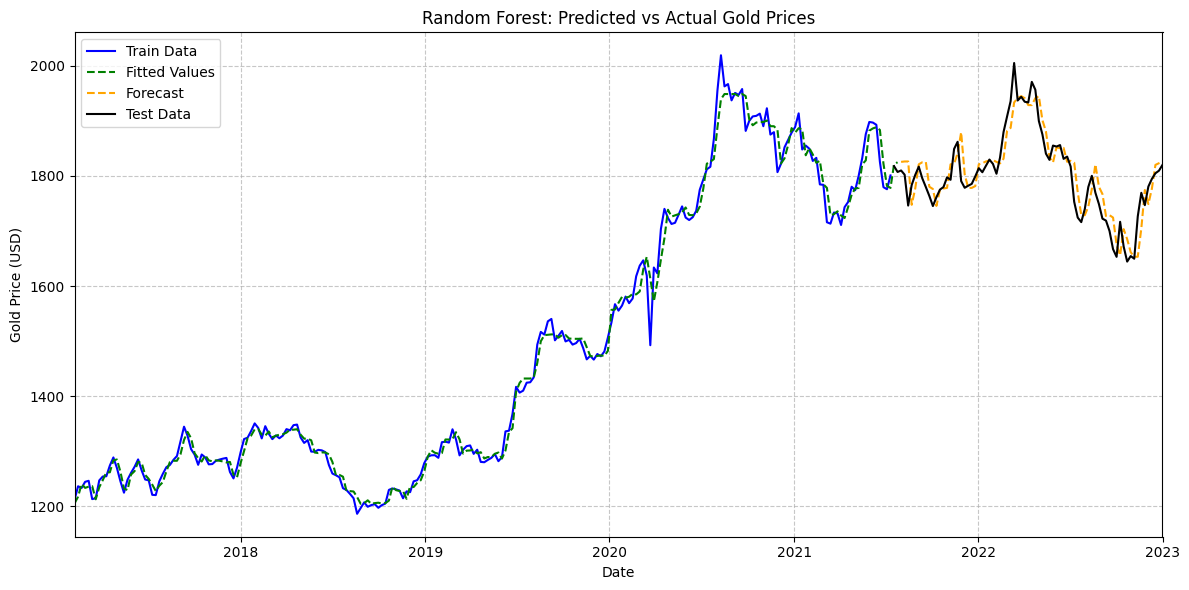

In [ ]:
# Fitted values
rf_fitted = rf_model.predict(X_train)  # Predictions on training data

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data', color='blue')
plt.plot(train_indices, rf_fitted, label='Fitted Values', color='green', linestyle='--')
plt.plot(test_indices, rf_forecast, label='Forecast', color='orange', linestyle='--')
plt.plot(test_data, label='Test Data', color='black')
plt.title('Random Forest: Predicted vs Actual Gold Prices', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Gold Price (USD)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(train_indices[0], test_indices[-1])
plt.tight_layout()
plt.show()

### **Results**

In [ ]:
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast)) # Now you can use 'np'
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))
des_rmse = np.sqrt(mean_squared_error(test_data, des_forecast))
tes_rmse = np.sqrt(mean_squared_error(test_data, tes_forecast))

rmse_values = [arima_rmse, rmse_rf, des_rmse, tes_rmse]
model_names = ["ARIMA", "Random Forest","Exponential 2","Exponential 3"]

# Sorting results
sorted_indices = np.argsort(rmse_values)
print("RMSE Results:\n")
for index in sorted_indices:
    print(f"{model_names[index]}: {rmse_values[index]}")

RMSE Results:

Random Forest: 33.189992654554686
ARIMA: 76.69292944883475
Exponential 2: 156.71461821004556
Exponential 3: 161.20702847593697


### **Actual vs Predicted Values**

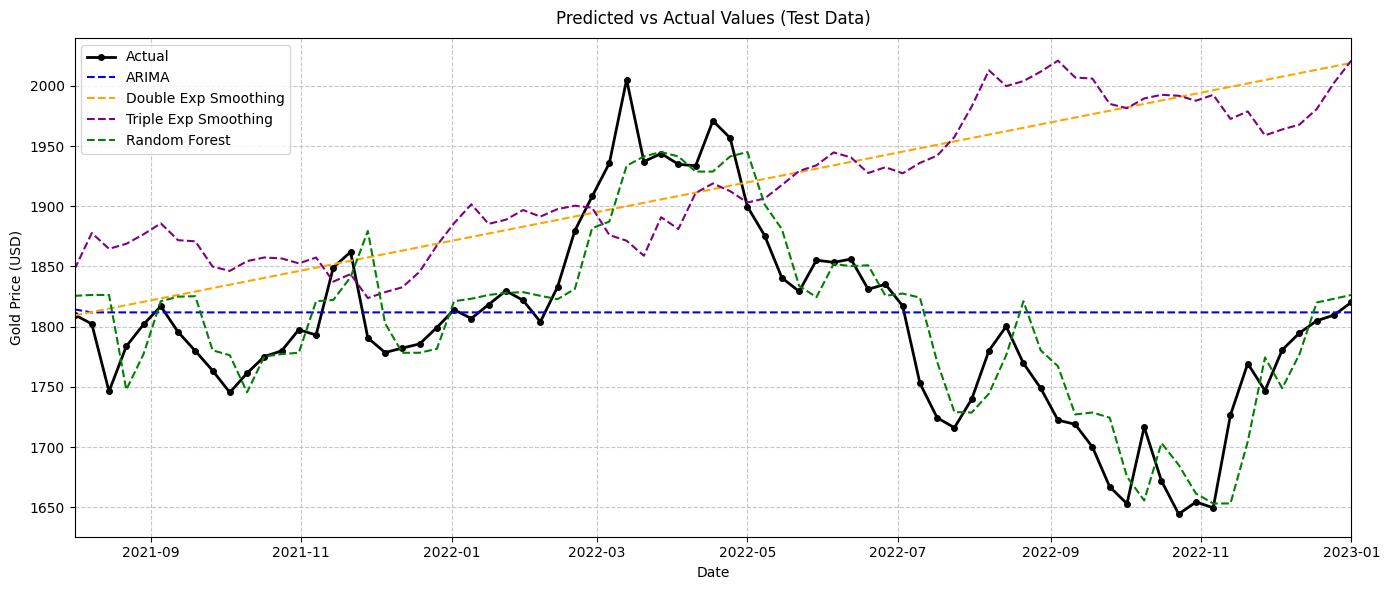

In [ ]:
plt.figure(figsize=(14, 6))

# Plot Actual Values
plt.plot(test_indices, y_test, label='Actual', color='black', linewidth=2, marker='o', markersize=4)

# Plot Predicted Values for each model
plt.plot(test_indices, arima_forecast[-len(test_indices):], label='ARIMA', color='blue', linewidth=1.5, linestyle='--')
plt.plot(test_indices, des_forecast[-len(test_indices):], label='Double Exp Smoothing', color='orange', linewidth=1.5, linestyle='--')
plt.plot(test_indices, tes_forecast[-len(test_indices):], label='Triple Exp Smoothing', color='purple', linewidth=1.5, linestyle='--')
plt.plot(test_indices, rf_forecast, label='Random Forest', color='green', linewidth=1.5, linestyle='--')

# titles, labels, and legend
plt.title('Predicted vs Actual Values (Test Data)', fontsize=12, pad=10)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Gold Price (USD)', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(test_indices[0], test_indices[-1])
plt.tight_layout()
plt.show()

### **Diagnostics**

**Random Forest Diagnostics**

Training RMSE: 20.738684854637295
Test RMSE: 33.189992654554686


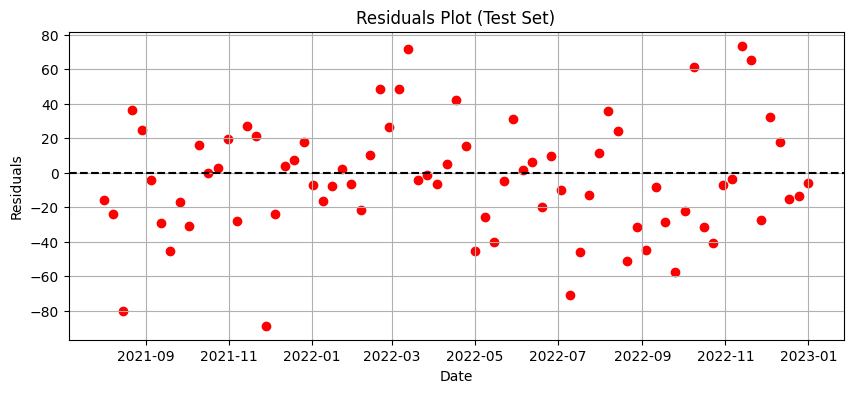

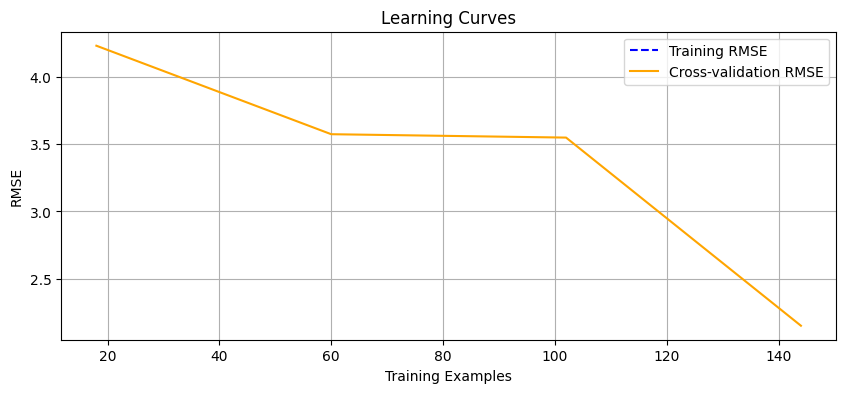

Feature Importance:
   Feature  Importance
0    Year    0.472944
1    Lag1    0.388938
2    Lag2    0.138119


In [ ]:
train_predictions = rf_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_predictions = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
if train_rmse < test_rmse * 0.9:  # If training RMSE is 10%+ lower than test
    print("Warning: Possible overfitting detected!")

residuals = y_test - test_predictions
plt.figure(figsize=(10, 4))
plt.scatter(X_test.index, residuals, c='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals Plot (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()
if np.any(np.abs(residuals) > test_rmse * 2):  # Large outliers
    print("Warning: Residuals suggest potential overfitting!")


train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train, y_train, cv=5, n_jobs=-1)
train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
test_rmse_mean = np.sqrt(-test_scores.mean(axis=1))
plt.figure(figsize=(10, 4))
plt.plot(train_sizes, train_rmse_mean, label='Training RMSE', color='blue',linestyle='--' )
plt.plot(train_sizes, test_rmse_mean, label='Cross-validation RMSE', color='orange')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
if train_rmse_mean[-1] < test_rmse_mean[-1] * 0.8:  # Significant gap
    print("Warning: Learning curve suggests overfitting!")

feature_importance = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
print("Feature Importance:\n", importance_df.sort_values('Importance', ascending=False))
if rf_model.max_depth and rf_model.max_depth > 6:
    print("Warning: High max_depth may contribute to overfitting!")

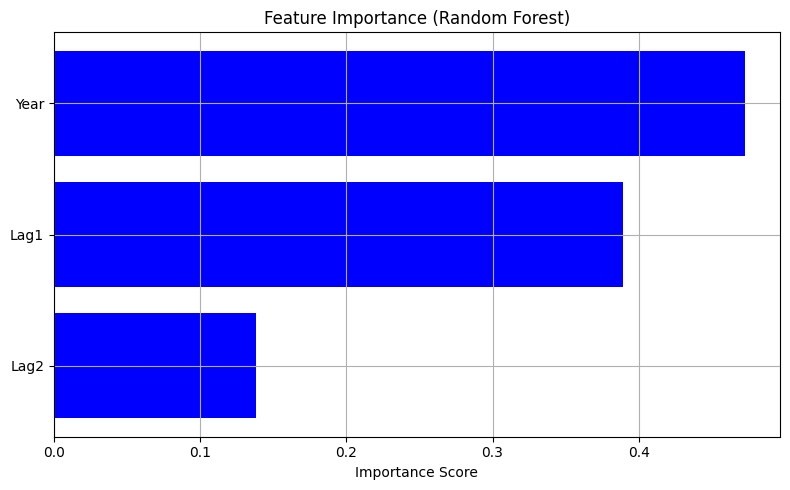

In [ ]:
# feature importances
importances = rf_model.feature_importances_
features = X_train.columns

# Plot
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

Training RMSE: 20.738684854637295
Test RMSE: 33.189992654554686


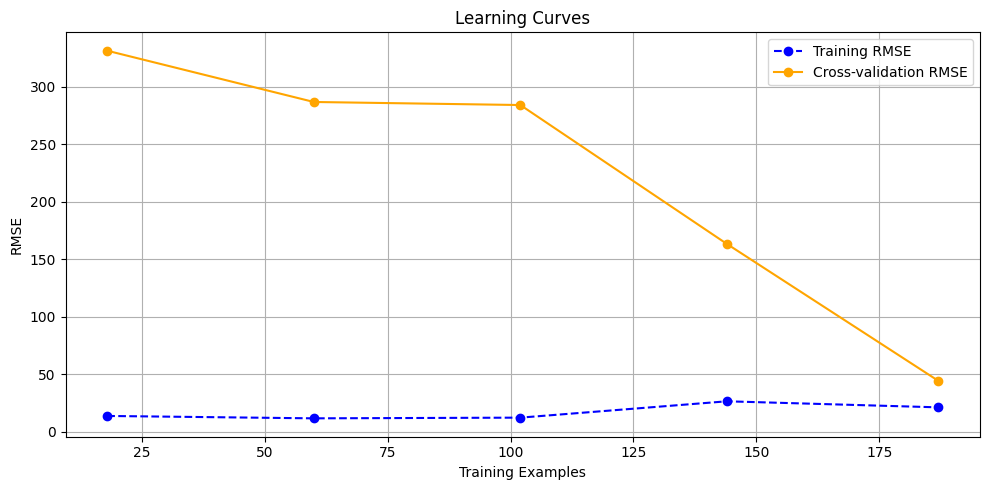

In [ ]:
#Learning Curve
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# RMSE from negative MSE scores
train_rmse_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_rmse_mean = np.sqrt(-np.mean(test_scores, axis=1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_rmse_mean, label='Training RMSE', color='blue', linestyle='--', marker='o')
plt.plot(train_sizes, test_rmse_mean, label='Cross-validation RMSE', color='orange', marker='o')
plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# k - fold Cross Validation

# X and y are your features and target variable
X = weekly_df[['Year', 'Lag1', 'Lag2']]
y = weekly_df['Price']

# Number of folds
n_splits = 5  # Example: 5-fold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_model = RandomForestRegressor(n_estimators=50, max_depth=8, min_samples_split=10, min_samples_leaf=4, random_state=42)
    rf_model.fit(X_train, y_train)

    rf_predictions = rf_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
    rmse_scores.append(rmse)

print("RMSE scores for each fold:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))


RMSE scores for each fold: [np.float64(37.438453793741274), np.float64(29.24847345595184), np.float64(24.626801744499904), np.float64(31.08579727341307), np.float64(26.65003095280723)]
Average RMSE: 29.809911444082665


**ARIMA Diagnostics**

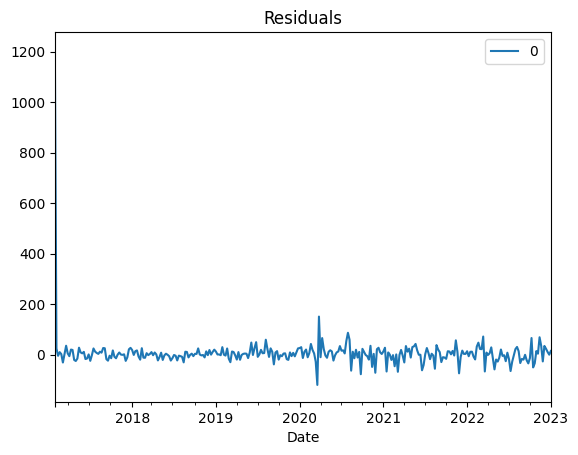

In [ ]:
#Residual Plots
# Fit the ARIMA(0,1,4) model
model = ARIMA(weekly_df["Price"], order=(0, 1, 4))
arima_fit = model.fit()

# Plot residuals
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot(title="Residuals")
plt.show()

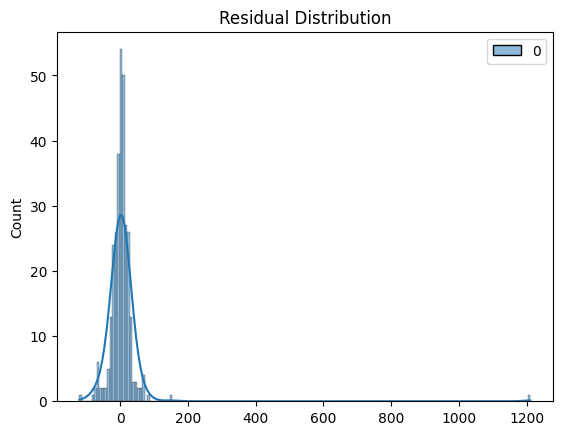

In [ ]:
#Residual Distribution
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

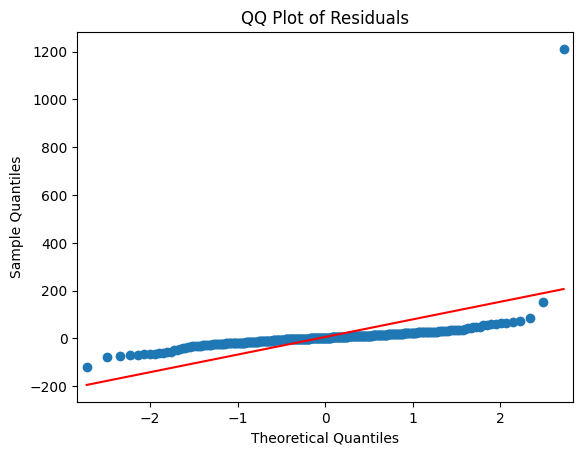

In [ ]:
#QQ
sm.qqplot(residuals.squeeze(), line='s')
plt.title("QQ Plot of Residuals")
plt.show()

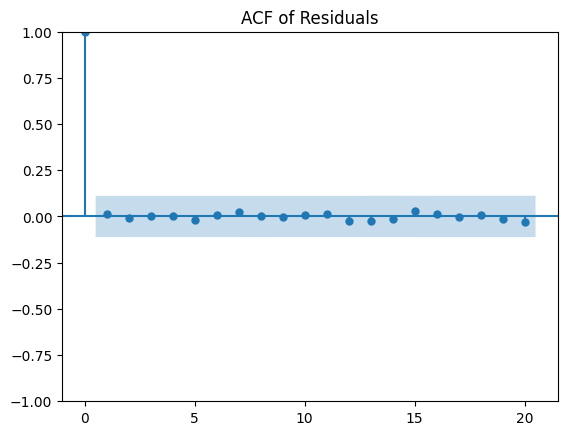

In [ ]:
plot_acf(residuals.squeeze(), lags=20)
plt.title("ACF of Residuals")
plt.show()

In [ ]:
arima_residuals = arima_fit.resid

#mean of residuals
mean_residual = np.mean(arima_residuals)
print(f"Mean of ARIMA residuals: {mean_residual:.4f}")

#variance of residuals
variance_residual = np.var(arima_residuals)
print(f"Variance of ARIMA residuals: {variance_residual:.4f}")

Mean of ARIMA residuals: 5.9454
Variance of ARIMA residuals: 5421.4067


In [ ]:
from scipy.stats import shapiro

arima_residuals = arima_fit.resid

# Shapiro-Wilk normality test
shapiro_test_stat, shapiro_p_value = shapiro(arima_residuals)

print(f"Shapiro-Wilk Test Statistic: {shapiro_test_stat:.4f}")
print(f"P-value: {shapiro_p_value:.4f}")

if shapiro_p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals are not normally distributed (reject H0).")

Shapiro-Wilk Test Statistic: 0.2556
P-value: 0.0000
Residuals are not normally distributed (reject H0).


In [ ]:
# AICC and BIC

print("ARIMA")
print(f'BIC: {arima_fit.bic}')
print(f'AICC: {arima_fit.aicc}')

print("DES")
print(f'BIC: {des_fit.bic}')
print(f'AICC: {des_fit.aicc}')

print("TES")
print(f'BIC: {tes_fit.bic}')
print(f'AICC: {tes_fit.aicc}')

ARIMA
BIC: 2925.574874511991
AICC: 2907.1230510938117
DES
BIC: 1540.50997143039
AICC: 1527.0587310218225
TES
BIC: 1756.771956195109
AICC: 1602.382545163649


**Double Exponential Smoothing Diagnostics**

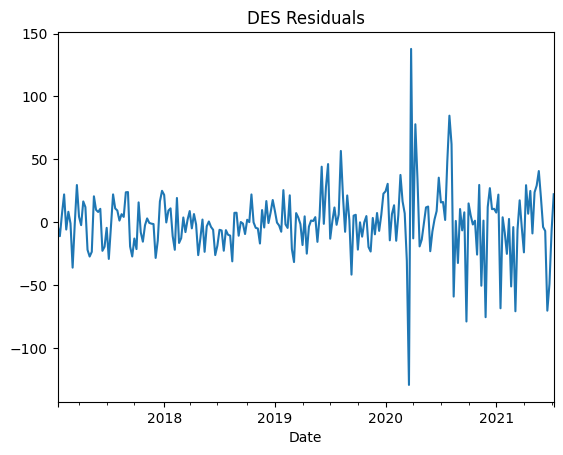

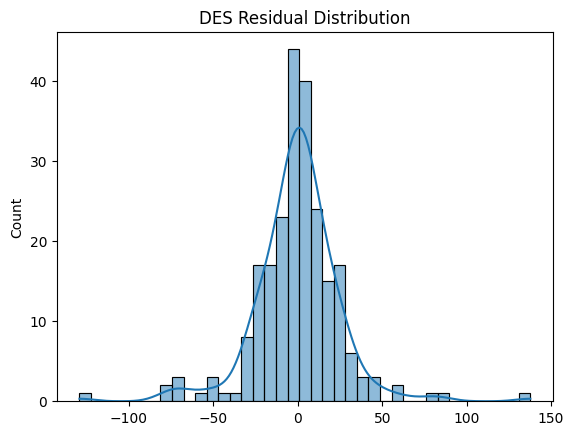

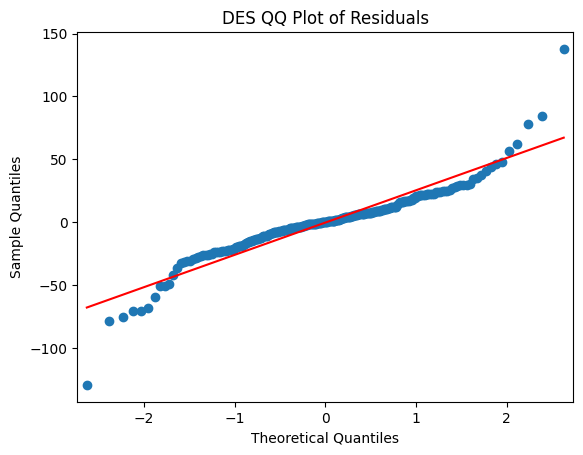

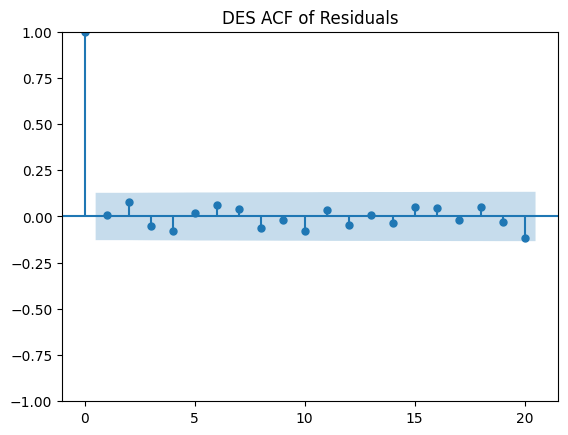

In [ ]:
des_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
des_fit = des_model.fit(optimized=True)
des_residuals = des_fit.resid

#Plot Residuals for DES
des_residuals.plot(title="DES Residuals")
plt.show()
sns.histplot(des_residuals, kde=True)
plt.title("DES Residual Distribution")
plt.show()

sm.qqplot(des_residuals, line='s')
plt.title("DES QQ Plot of Residuals")
plt.show()
plot_acf(des_residuals, lags=20)
plt.title("DES ACF of Residuals")
plt.show()

**Triple Exponential Smoothing Diagnostics**

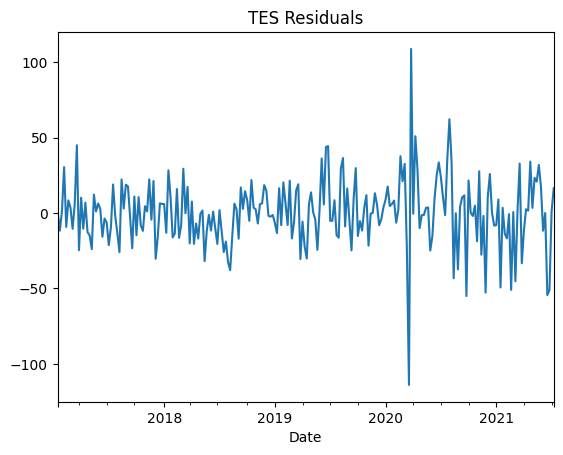

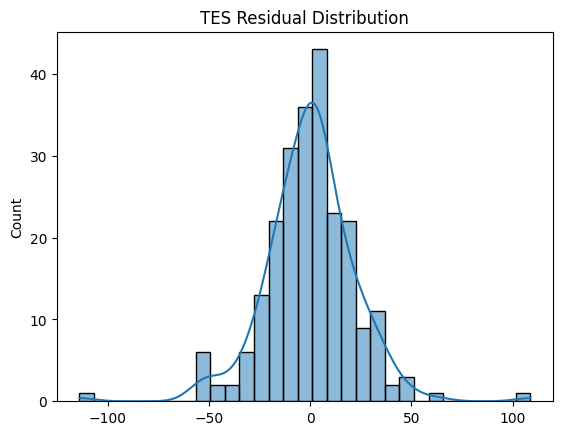

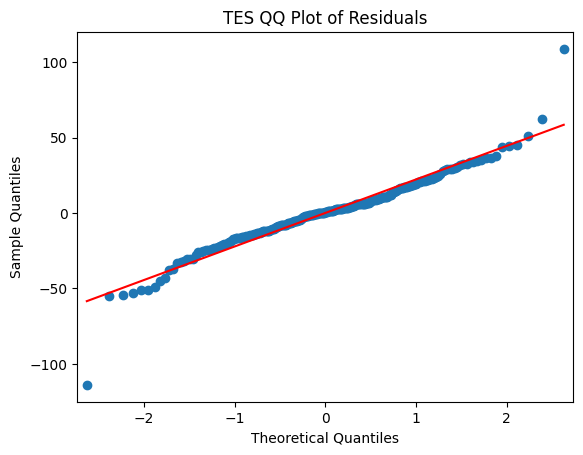

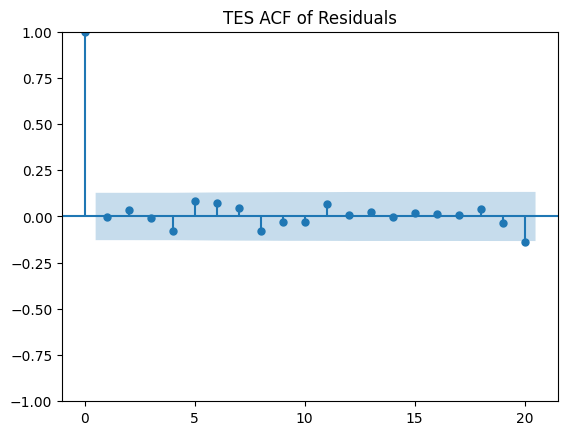

In [ ]:
tes_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=52)
tes_fit = tes_model.fit(optimized=True)
tes_residuals = tes_fit.resid

#Plot Residuals for TES
tes_residuals.plot(title="TES Residuals")
plt.show()

sns.histplot(tes_residuals, kde=True)
plt.title("TES Residual Distribution")
plt.show()

sm.qqplot(tes_residuals, line='s')
plt.title("TES QQ Plot of Residuals")
plt.show()
plot_acf(tes_residuals, lags=20)
plt.title("TES ACF of Residuals")
plt.show()


### **Forecast**

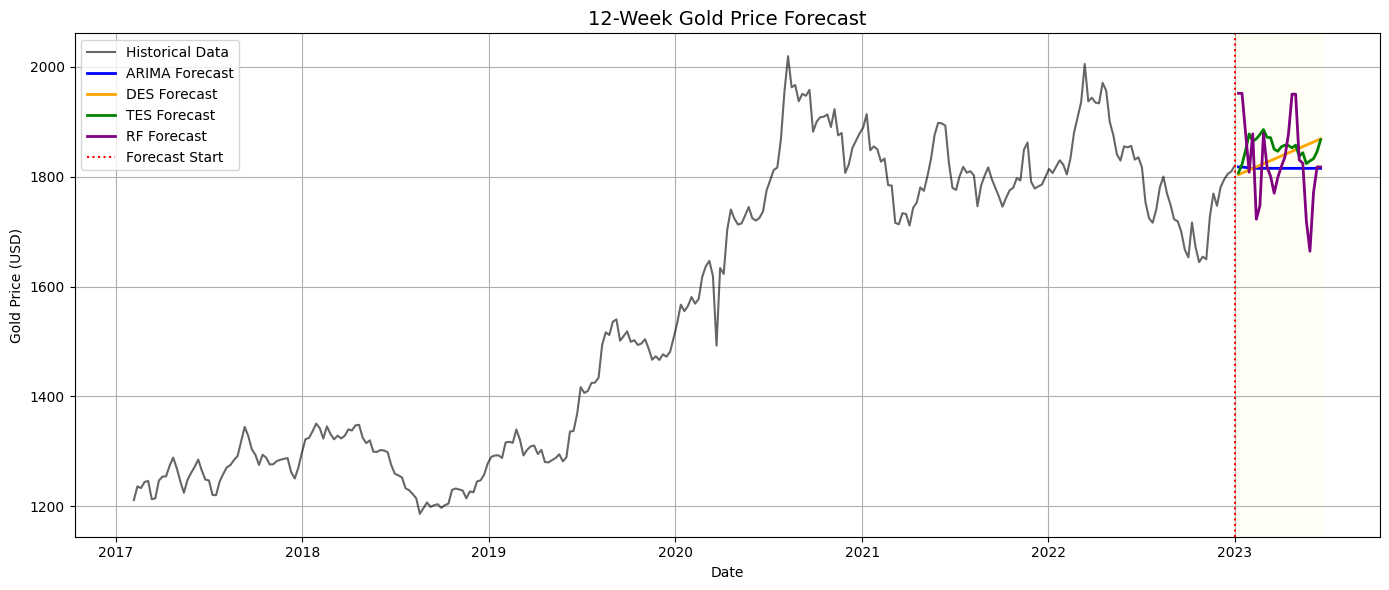

In [ ]:
# Future dates for 24-week forecast
last_date = weekly_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=24, freq='W')

# ARIMA forecast
arima_future_forecast = arima_fit.forecast(steps=24)

# DES forecast
des_future_forecast = des_fit.forecast(24)

# TES forecast
tes_future_forecast = tes_fit.forecast(24)

# Random Forest forecast
rf_future_forecast = rf_model.predict(X_test.tail(24))

# Plotting
plt.figure(figsize=(14, 6))

plt.plot(weekly_df.index, weekly_df['Price'], label='Historical Data', color='black', linewidth=1.5, alpha=0.6)
plt.axvspan(last_date, future_dates[-1], color='lightyellow', alpha=0.3)
plt.plot(future_dates, arima_future_forecast, label='ARIMA Forecast', color='blue', linestyle='-', linewidth=2)
plt.plot(future_dates, des_future_forecast, label='DES Forecast', color='orange', linestyle='-', linewidth=2)
plt.plot(future_dates, tes_future_forecast, label='TES Forecast', color='green', linestyle='-', linewidth=2)
plt.plot(future_dates, rf_future_forecast, label='RF Forecast', color='purple', linestyle='-', linewidth=2)
plt.axvline(x=last_date, color='red', linestyle=':', label='Forecast Start')

# Titles and formatting
plt.title('12-Week Gold Price Forecast', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
